<img src = "https://scx2.b-cdn.net/gfx/news/hires/2022/ride-into-orbit-secure.jpg" style = "height:360px; width:900px; opacity: 1"/>

# <center> Satellite image segmentation with KMeans </center>

This notebook will present the application of two segmentation models on satellite images. The main idea is to exploit segmentation for differentiating cropland areas within a color image of dimension (64 x 64 x 3), and more precisely, to be capable of estimating the amount of non-cultivated land. This is done by first segmenting the images and then converting them into a two-dimensional image (64 x 64) by converting them into a monochromatic (greyscale) image. Then, with a threshold intrinsic to each image, we separate the image into two categories: cultivated and non-cultivated land, so we can estimate the surface corresponding to the land pending for cultivation.

The notebook is composed by:
1. [Scikit-learn K-Means](#1)
2. [Opencv K-Means](#2)
4. [Silhouette coefficient](#3)
3. [Contour](#4)

Firstly, we import the libraries required for the project: in addition to the usual Python and `OpenCV` libraries, we call custom functions from our in-house library: `image_tools`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import skimage
import cv2
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union
# Import from custom library since its located in another directory
import sys  
sys.path.insert(0, '../Scripts/')

from image_tools import clustering_km, cv2_clustering_km, draw_contour, polygon_from_contour, generate_dataset, compute_area

In addition, we are going to use the following functions that compare the original image with the segmented image and its three RGB channels, and display the outputs of each step: from the segmentation to the splitting and computing of the image contour.

In [3]:
def plotseg(image, segmented_image, title = None):
    fig, ax = plt.subplots(1, 5, figsize = (19, 3))

    ax[0].imshow(image)
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(segmented_image, cmap = 'viridis')
    ax[1].set_title('Segmented image')
    ax[1].axis('off')

    for i in range(3):
        ax[i+2].set_title('Channel: {}'.format("RGB"[i]))
        ims = ax[i+2].imshow(segmented_image[:,:,i])
        ax[i+2].axis('off')

    p0 = ax[2].get_position().get_points().flatten()
    p1 = ax[3].get_position().get_points().flatten()
    p2 = ax[4].get_position().get_points().flatten()
    ax_cbar = fig.add_axes([p0[0], 0, p2[2]-p0[0], 0.05])
    plt.colorbar(ims, cax=ax_cbar, orientation='horizontal')
    
    if title:
        plt.suptitle(title, size=14, y=1.1)

    plt.show()
    
def plotevo(image, segmented_image, bin_image, contour, title = None):
    fig, ax = plt.subplots(1, 4, figsize = (16.5, 3))

    ax[0].imshow(image)
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(segmented_image)
    ax[1].set_title('Segmented image')
    ax[1].axis('off')

    ims = ax[2].imshow(bin_image, cmap = 'binary')
    ax[2].set_title('Monochromatic (grey) image')
    ax[2].axis('off')
    plt.colorbar(ims, ax = ax[2], fraction = 0.045)

    ax[3].imshow(contour.astype(np.uint8))
    ax[3].set_title('Segmented image contour')
    ax[3].axis('off')
    
    if title:
        plt.suptitle(title, size=14, y=1.1)

    plt.show()

We have trained the classification model using images from the EuroSat dataset, so we are going to perform the segmentation on the same dataset. However, using this dataset has its drawbacks because of the absence of layer masks, and thus we exclude the possibility of applying the segmentation models built in the OpenCV library, which display excellent results. However, there is a way out which consists in using unsupervised algorithms that don't require any other input besides the images. 
Here, we choose the classical K-means, despite the inconvenience of having to provide a fixed value for the expected number of clusters. 
<br> This model is available in the scikit-learn and OpenCV libraries. This makes it worthwhile to discuss the results achieved by these two different implementations. Since a comparison on 30,000 images is practically infeasible, we will content ourselves with considering a few cases of a potential real-world scenario. 

In [4]:
path_train = "../Data/EuroSat/2750/Training/"
path_test = "../Data/EuroSat/2750/Test/"

class_names = os.listdir(path_train)

image_size = (64, 64)

In [4]:
images_path = [np.random.choice(os.listdir(path_train + class_)) for class_ in class_names]

In [7]:
images_path

['AnnualCrop_1331.jpg',
 'Forest_174.jpg',
 'HerbaceousVegetation_2433.jpg',
 'Highway_929.jpg',
 'Industrial_2365.jpg',
 'Pasture_1894.jpg',
 'PermanentCrop_1387.jpg',
 'Residential_344.jpg',
 'River_807.jpg',
 'SeaLake_1432.jpg']

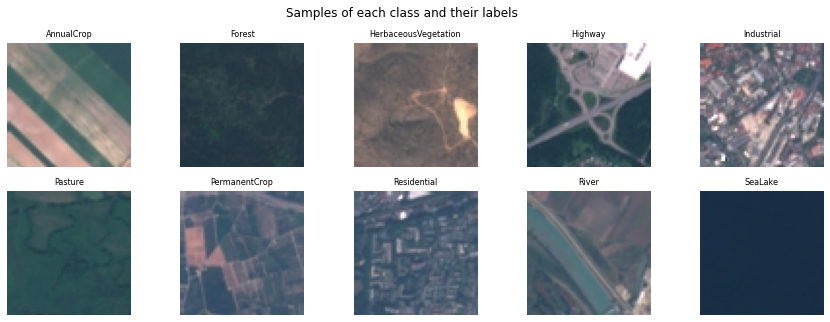

In [34]:
nrow, ncol = 2, 5

_, ax = plt.subplots(nrow, ncol, figsize=(15, 5))
plt.suptitle("Samples of each class and their labels")
for i, images, label in zip(range(10), images_path, class_names):
    ax[i//ncol, i%ncol].imshow(plt.imread(path_train + label +'/' + images))
    ax[i//ncol, i%ncol].set_title("{}".format(label), fontsize = 8)
    ax[i//ncol, i%ncol].axis("off")

plt.show()

The K-means algorithm is an unsupervised learning approach in which the points are assigned to a cluster based on their proximity to its centroid. This algorithm is particularly interesting when we want to regroup the data into a certain number k of clusters. If the actual number of clusters can't be specified, then it becomes more delicate to run this algorithm, as its results can drastically differ depending on the value set to the parameter k. This algorithm is also a common technique for image segmentation since it involves no prior training.
<br> Initially, we will use the scikit-learn library's implementation of this algorithm, before moving into the OpenCV version.

<a id="1"></a>
## Scikit-learn K-means

In [8]:
image_path = f"{path_train}AnnualCrop/AnnualCrop_10.jpg"

In [12]:
def sk_kmeans_segmentation(filepath, n_clusters):
    img = plt.imread(filepath)
    centroids, labels = clustering_km(img, n_clusters)
    segmented_img = np.choose(labels, centroids).astype(np.uint8).reshape(img.shape)
    return img, segmented_img

In [19]:
# Segment the image
sk_img, sk_segmented_image_k3 = sk_kmeans_segmentation(image_path, 3)
sk_img, sk_segmented_image_k4 = sk_kmeans_segmentation(image_path, 4)

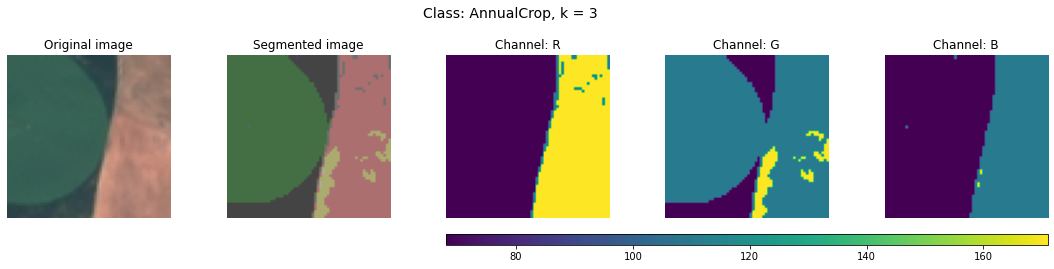

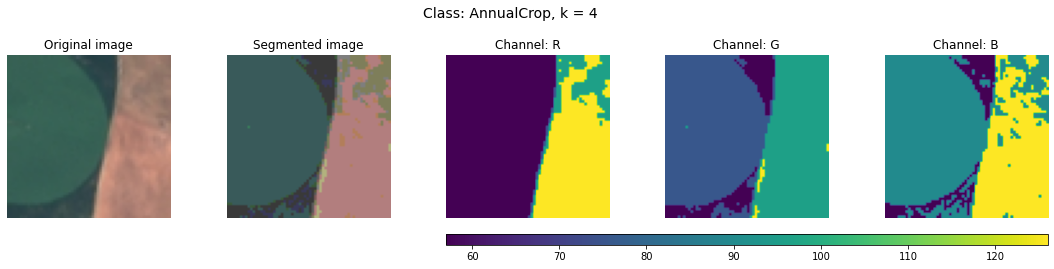

In [20]:
# Display the results
plotseg(sk_img, sk_segmented_image_k3, "Class: AnnualCrop, k = 3")
plotseg(sk_img, sk_segmented_image_k4, "Class: AnnualCrop, k = 4")

These are the results we have obtained on an image of a culture where 3 differentiated regions can be identified. In the resulting top image it can be observed that 4 clusters are recognizable, although only three clusters have been selected within the algorithm. Equally, when selecting 4 clusters, three distinct groups are apparent plus a fourth one in the upper right quadrant. 
<br> The lesson we can draw is that the implementation is very sensitive to noise and that's the reason why the two resulting images present patches of different color surrounding the main clusters. Finally, as we have already pointed out above, the results derived from each parameter k differ significantly one from the other.

<a id="2"></a>
## OpenCV K-means

In [21]:
image_path = f"{path_train}AnnualCrop/AnnualCrop_10.jpg"

In [22]:
def cv_kmeans_segmentation(filepath, n_clusters, eps):
    img = plt.imread(filepath)
    segmented_img = cv2_clustering_km(img, n_clusters, eps)
    return img, segmented_img

In [23]:
# Segment the image
cv_img, cv_segmented_image_k3 = cv_kmeans_segmentation(image_path, 3, 0.7)
cv_img, cv_segmented_image_k4 = cv_kmeans_segmentation(image_path, 4, 0.7)

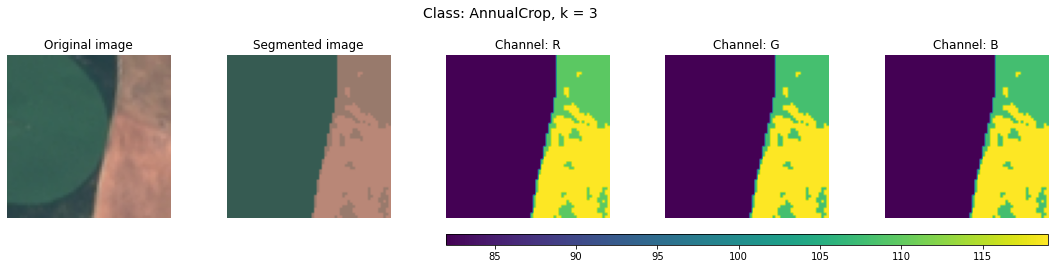

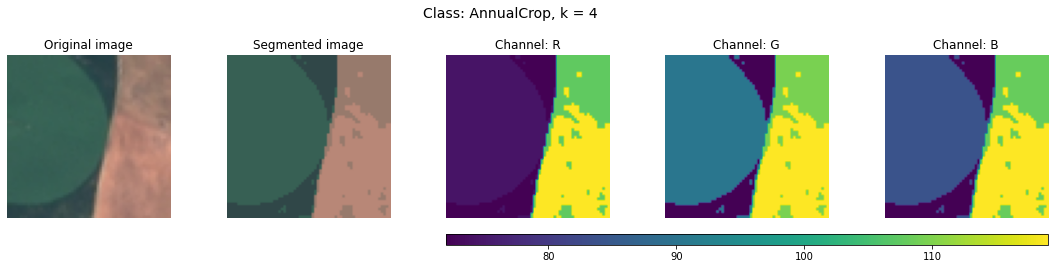

In [24]:
# Display the results
plotseg(cv_img, cv_segmented_image_k3, "Class: AnnualCrop, k = 3")
plotseg(cv_img, cv_segmented_image_k4, "Class: AnnualCrop, k = 4")

We present here the results we have obtained on the crop image where 3 differentiated regions can be seen. The top image clearly depicts 3 clusters and in the same way, using 4 clusters, we can see 4 well separable clusters.
We can first conclude that, contrary to the K-means of scikit-learn, this implementation is much less sensitive to noise and as a result, clusters become more recognizable in both of the segmented images, which means that clusters are produced more accurately in both of the outputs.
<br> Yet, the figures obtained for each of the parameters k diverge markedly, since for $k = 3$, the semi-circle is completely merged with the field. Lastly, the three channels of the segmented image appear to be practically identical.

<a id="4"></a>
## Contour

Finally, we choose the segmented image and then we transform it into a monochromatic image, so we can separate the image into two main regions based on a threshold, and ultimately choose the contours of one of these regions.
In this example, we will proceed with the images that we previously segmented using the K-means algorithm from the scikit-learn and opencv libraries. In order to have more insight on the influence of the $k$-value (number of separated regions), we will make a quick comparison of the results for $k = 3$ and $k = 4$.

Por definición, se considerará como terreno no cultivado, aquel donde no haya una presencia evidente de vegetación. En ciertos casos, y ya que es imposible realizar una distinción, también podrán ser confundidos con los terrenos no cultivados, los terrenos donde si haya habido un cultivo que se encuentre en las primeras fases de germinación.

### Sklearn

In [25]:
# Transform the segmented color image into a monochrome image
sk_img_grey_k3 = cv2.cvtColor(sk_segmented_image_k3, cv2.COLOR_BGR2GRAY)
sk_img_grey_k4 = cv2.cvtColor(sk_segmented_image_k4, cv2.COLOR_BGR2GRAY)
# Set the threshold using 
sk_thresh_k3 = np.quantile(sk_img_grey_k3, 0.5)
sk_thresh_k3_ = np.quantile(sk_img_grey_k3, 0.61)
sk_thresh_k4 = np.quantile(sk_img_grey_k4, 0.5)
# Apply the threshold and compute the contours of the segmented image
sk_contour_k3, sk_cont_k3 = draw_contour(sk_segmented_image_k3, sk_thresh_k3, 'binary')
sk_contour_k3_, sk_cont_k3_ = draw_contour(sk_segmented_image_k3, sk_thresh_k3_, 'binary')
sk_contour_k4, sk_cont_k4 = draw_contour(sk_segmented_image_k4, sk_thresh_k4, 'binary')

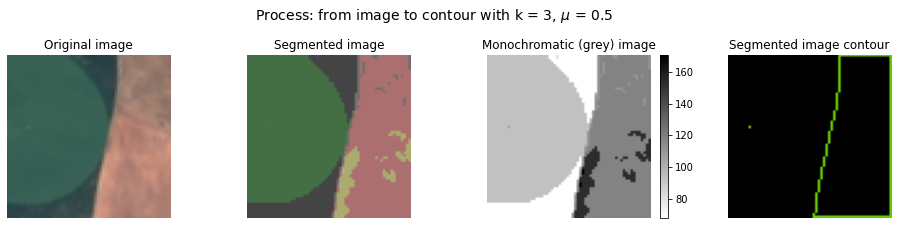

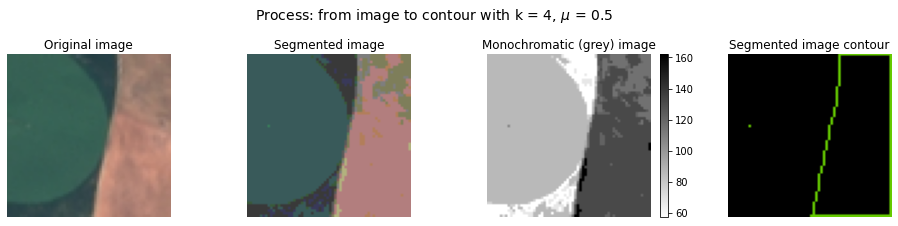

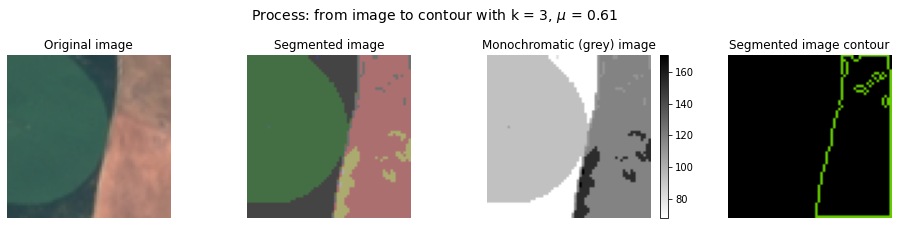

In [26]:
# Display the results
plotevo(sk_img, sk_segmented_image_k3, sk_img_grey_k3, sk_contour_k3, 'Process: from image to contour with k = 3, $\mu$ = 0.5')
plotevo(sk_img, sk_segmented_image_k4, sk_img_grey_k4, sk_contour_k4, 'Process: from image to contour with k = 4, $\mu$ = 0.5')
plotevo(sk_img, sk_segmented_image_k3, sk_img_grey_k3, sk_contour_k3_, 'Process: from image to contour with k = 3, $\mu$ = 0.61')

Note that the conversion of the segmented image into a monochrome image preserves the main characteristics of the segmented image, a positive sign since there is no significant trade-off in the loss of information.
Moreover, this conversion also serves to bring out the noise in the case of the scikit-learn implementation, and therefore, denoising would be much easier.
After thresholding, the contour obtained using respectively 3 and 4 clusters is practically the same. However, there is a very small region consisting of noise, and despite having practically a null area, it is preferable to reduce the noise as much as possible.
Finally, if the threshold is slightly modified, one can see how the outcome will significantly change, which underlines the necessity of choosing the right threshold, and moreover, in this particular example, the impact of the threshold is greater than that of the $k$-value.

In [27]:
print("{:.1f} % of unused Area".format(compute_area(sk_cont_k3, return_pct = True, image_size = sk_contour_k3.shape)))
print("{:.1f} % of unused Area".format(compute_area(sk_cont_k4, return_pct = True, image_size = sk_contour_k4.shape)))
print("{:.1f} % of unused Area".format(compute_area(sk_cont_k3_, return_pct = True, image_size = sk_contour_k3_.shape)))

37.1 % of unused Area
37.4 % of unused Area
35.5 % of unused Area


While there is no visual difference between the contours for $k = 3$ and $k = 4$ for the same threshold, such difference does exist, but in percentage terms it is small. Nevertheless, if we want to estimate the surface, these differences can have a considerable impact, depending on the resolution of the image (5m, 10m, 30m, etc.). The difference between $\mu = 0.5$ and $\mu = 0.61$ is more striking to the eye, and in terms of percentage stands at around 2%.

### Opencv

In [28]:
# Transform the segmented color image into a monochrome image
cv_img_grey_k3 = cv2.cvtColor(cv_segmented_image_k3, cv2.COLOR_BGR2GRAY)
cv_img_grey_k4 = cv2.cvtColor(cv_segmented_image_k4, cv2.COLOR_BGR2GRAY)
# Set the threshold using 
cv_thresh_k3 = np.quantile(cv_img_grey_k3, 0.5)
cv_thresh_k3_ = np.quantile(cv_img_grey_k3, 0.61)
cv_thresh_k4 = np.quantile(cv_img_grey_k4, 0.5)
# Apply the threshold and compute the contours of the segmented image
cv_contour_k3, cv_cont_k3 = draw_contour(cv_segmented_image_k3, cv_thresh_k3, 'binary')
cv_contour_k3_, cv_cont_k3_ = draw_contour(cv_segmented_image_k3, cv_thresh_k3_, 'binary')
cv_contour_k4, cv_cont_k4 = draw_contour(cv_segmented_image_k4, cv_thresh_k4, 'binary')

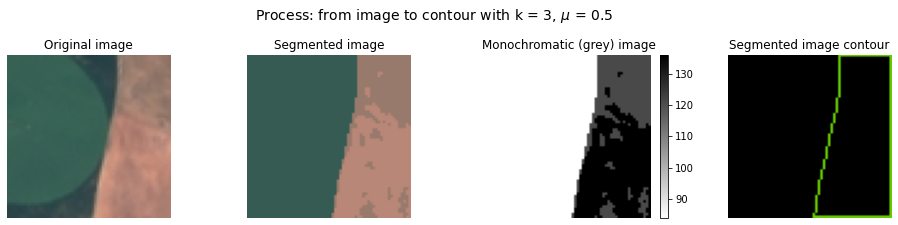

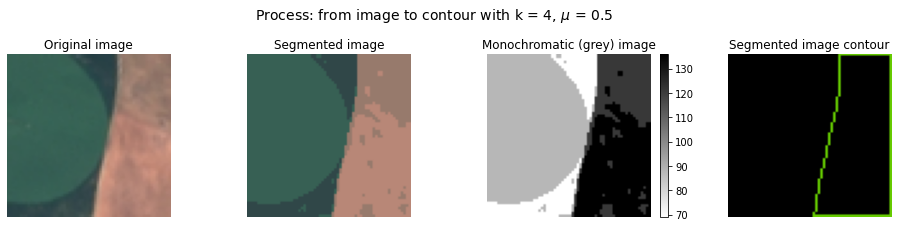

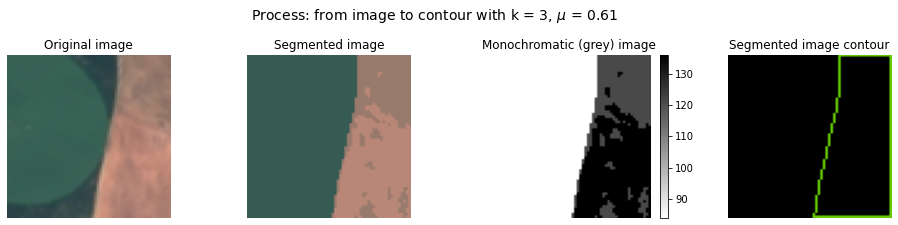

In [29]:
# Display the results
plotevo(cv_img, cv_segmented_image_k3, cv_img_grey_k3, cv_contour_k3, 'Process: from image to contour with k = 3, $\mu$ = 0.5')
plotevo(cv_img, cv_segmented_image_k4, cv_img_grey_k4, cv_contour_k4, 'Process: from image to contour with k = 4, $\mu$ = 0.5')
plotevo(cv_img, cv_segmented_image_k3, cv_img_grey_k3, cv_contour_k3_, 'Process: from image to contour with k = 3, $\mu$ = 0.61')

In this implementation, the main features of the segmented image are also preserved during its conversion to a monochrome image. Unlike the scikit-learn implementation, the absence of noise (there is no more clusters created than previously specified) makes the setting of a threshold much simpler, since the risk of "accepting" non-target regions is reduced.
The application of thresholding yields the same boundary, be it using 3 or 4 clusters, in spite of segmented images differing markedly from each other. Here, adjusting the threshold doesn't affect the final result, which suggests that this implementation is less sensitive to threshold adjustment.

In [30]:
print("{:.1f} % of unused Area".format(compute_area(cv_cont_k3, return_pct = True, image_size = cv_contour_k3.shape)))
print("{:.1f} % of unused Area".format(compute_area(cv_cont_k4, return_pct = True, image_size = cv_contour_k4.shape)))
print("{:.1f} % of unused Area".format(compute_area(cv_cont_k3_, return_pct = True, image_size = cv_contour_k3_.shape)))

36.8 % of unused Area
36.8 % of unused Area
36.8 % of unused Area


This gives an identical area, regardless of the number of clusters and the threshold selected. Also the estimated surface doesn't deviate enormously (between 0.3% and 0.6%) from the surface estimated from the scikit-learn implementation for $k = 3, 4$ and $\mu = 0.5$.

### Analysing contours

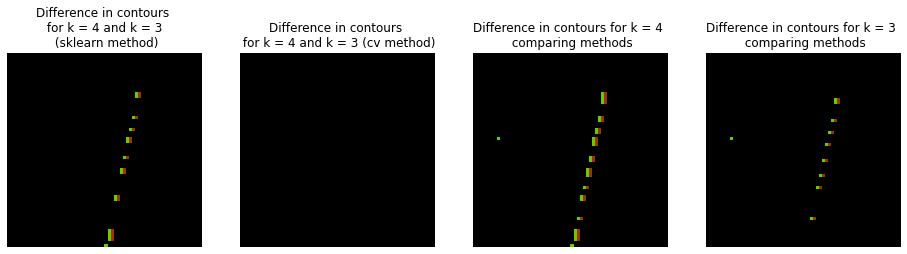

In [43]:
_, ax = plt.subplots(1, 4, figsize = (16, 4))

ax[0].imshow((sk_contour_k4 - sk_contour_k3).astype(np.uint8))
ax[0].set_title('Difference in contours \n for k = 4 and k = 3 \n (sklearn method)')
ax[0].axis('off')


ax[1].imshow((cv_contour_k4 - cv_contour_k3).astype(np.uint8))
ax[1].set_title('Difference in contours \n for k = 4 and k = 3 (cv method)')
ax[1].axis('off')

ax[2].imshow((sk_contour_k4 - cv_contour_k4).astype(np.uint8))
ax[2].set_title('Difference in contours for k = 4 \n comparing methods')
ax[2].axis('off')

ax[3].imshow((sk_contour_k3 - cv_contour_k3).astype(np.uint8))
ax[3].set_title('Difference in contours for k = 3 \n comparing methods')
ax[3].axis('off')

plt.show()

We first look at the difference between the contours achieved by the scikit-learn k-means for $k = 3$ and for $k = 4$, the two using $\mu = 0.5$. We can distinguish here two sets of colored pixels, green and red: green indicates the boundary obtained for $k = 4$ and red, respectively, the boundary for $k = 3$. The point to note is that the zoning for $k = 4$ differs by a few pixels from the zoning for $k = 3$, which causes the resulting area to differ by a small percentage.
<br> Looking at the OpenCV implementation, we notice a black figure, meaning that no discrepancy exists between the contours for $k = 3, 4$.
<br> When comparing the two methods, the OpenCV version excludes the noisy spot, giving a first visual difference, although the area of the noisy spot is zero. Besides, the contours of these two implementations are much alike when using $k=3$, as there is less presence of colored pixels in the image.

# Testing all categories

Following the review of the two implementations, we are going to test these algorithms in realistic conditions, in order to assess their efficacy and to point out their shortcomings. The most representative tests will be on the categories connected with the croplands, since our purpose is to be able to identify arable land. The other tests will be helpful for identifying the performance limits of both algorithms, while the conclusions we draw will help us in further projects. 

In [32]:
def process_segmentation(filepath, n_clusters, km_method = 'opencv', eps = 0.7, thresh = 0.5, t_method = 'binary', title = None):
    if km_method == 'sklearn':
        img, segmented_img = sk_kmeans_segmentation(filepath, n_clusters)
    elif km_method == 'opencv':
        img, segmented_img = cv_kmeans_segmentation(filepath, n_clusters, eps)
    else :
        raise ValueError("Unrecognized method: please try 'sklearn' or 'opencv'")

    img_grey = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)
    thresh = np.quantile(img_grey, thresh)
    contour, cont_ = draw_contour(segmented_img, thresh, t_method)
    plotevo(img, segmented_img, img_grey, contour, title)
    spacing = 11*'\t ' + '     '
    print("{} {:.1f} % of unused Area".format(spacing, compute_area(cont_, return_pct = True, image_size = contour.shape)))

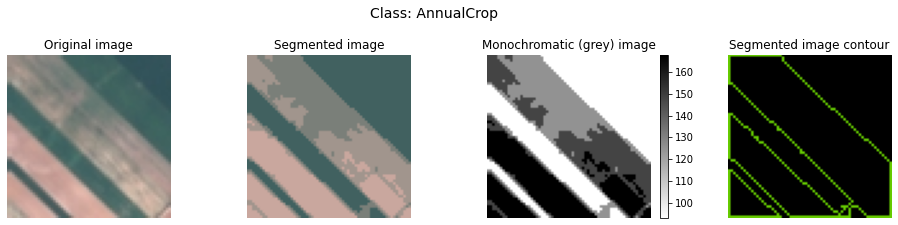

	 	 	 	 	 	 	 	 	 	 	       58.5 % of unused Area


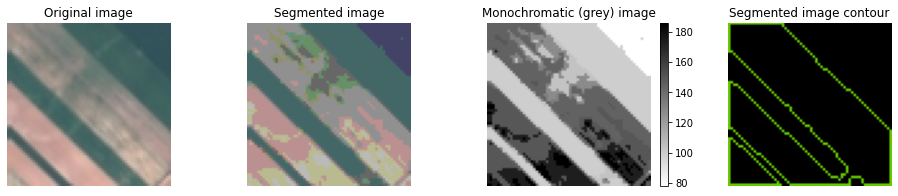

	 	 	 	 	 	 	 	 	 	 	       60.8 % of unused Area


In [33]:
idx = 0
filepath = "{}{}/{}".format(path_train, class_names[idx], images_path[idx])
title = "Class: {}".format(class_names[idx])
process_segmentation(filepath, 4 , thresh = 0.3, title = title)
process_segmentation(filepath, 4 , km_method = 'sklearn', thresh = 0.3)

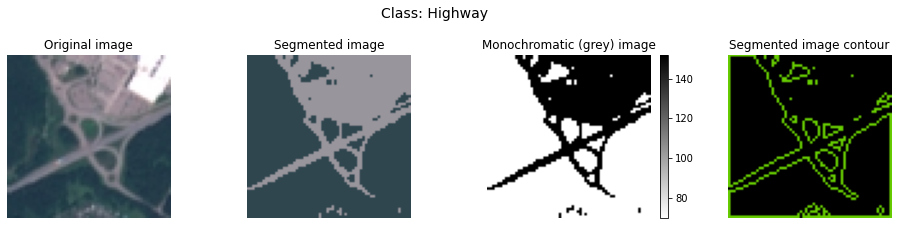

	 	 	 	 	 	 	 	 	 	 	       58.3 % of unused Area


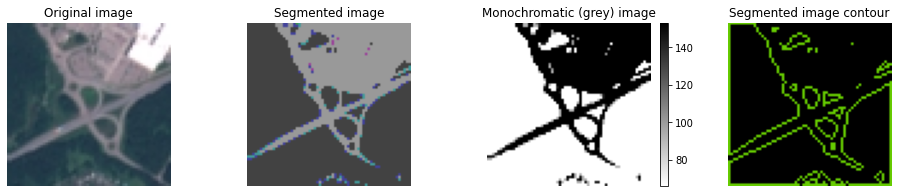

	 	 	 	 	 	 	 	 	 	 	       56.1 % of unused Area


In [34]:
idx = 3 
filepath = "{}{}/{}".format(path_train, class_names[idx], images_path[idx])
title = "Class: {}".format(class_names[idx])
process_segmentation(filepath, 2, t_method = 'binary_inv', title = title)
process_segmentation(filepath, 2, km_method = 'sklearn', t_method = 'binary_inv')

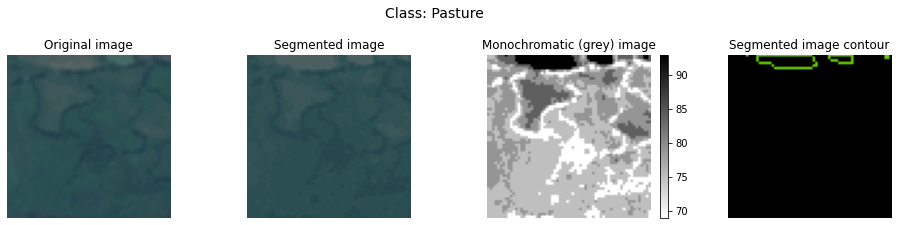

	 	 	 	 	 	 	 	 	 	 	       3.0 % of unused Area


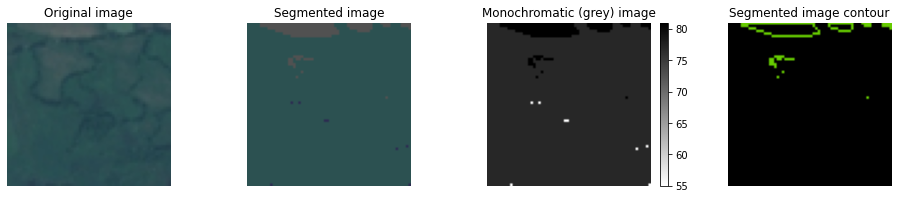

	 	 	 	 	 	 	 	 	 	 	       3.6 % of unused Area


In [97]:
idx = 5 
filepath = "{}{}/{}".format(path_train, class_names[idx], images_path[idx])
title = "Class: {}".format(class_names[idx])
process_segmentation(filepath, 5, title = title, thresh = .9)
process_segmentation(filepath, 2, km_method = 'sklearn')

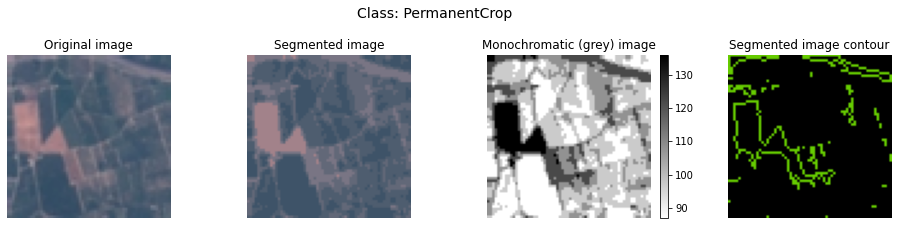

	 	 	 	 	 	 	 	 	 	 	       12.2 % of unused Area


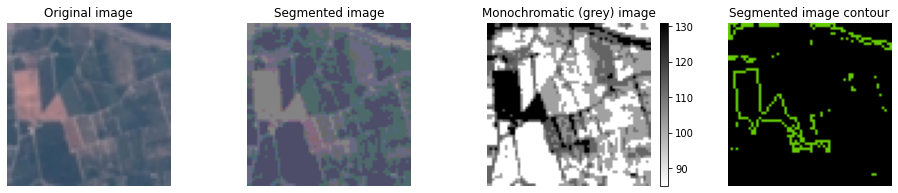

	 	 	 	 	 	 	 	 	 	 	       9.5 % of unused Area


In [158]:
idx = 6
filepath = "{}{}/{}".format(path_train, class_names[idx], images_path[idx])
title = "Class: {}".format(class_names[idx])
process_segmentation(filepath, 5, title = title, thresh = .7)
process_segmentation(filepath, 3, km_method = 'sklearn', thresh = .7)

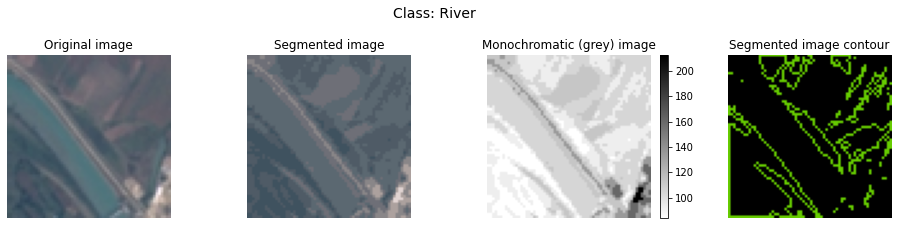

	 	 	 	 	 	 	 	 	 	 	       29.9 % of unused Area


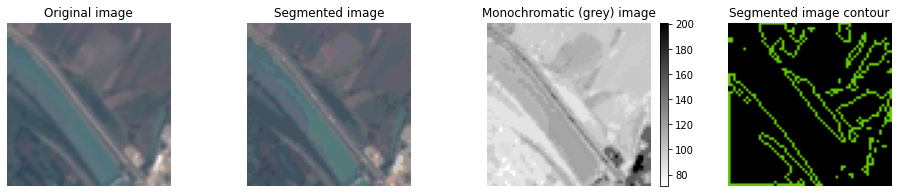

	 	 	 	 	 	 	 	 	 	 	       32.3 % of unused Area


In [222]:
idx = 8
filepath = "{}{}/{}".format(path_train, class_names[idx], images_path[idx])
title = "Class: {}".format(class_names[idx])
process_segmentation(filepath, 7, thresh = 0.35, t_method = 'trozero_inv', title = title)
process_segmentation(filepath, 7, km_method = 'sklearn', thresh = 0.35, t_method = 'trozero_inv')